Chunks for /content/Fin12.pdf:
Chunk #0:
1. Basis of Presentation and General Information (continued) Revenue Recognition The Company primarily generates its revenue from providing professional services to its clients. The Company also generates revenue from software sales, software maintenance and support and subscriptions to its executive and best practices advisory programs. A single contract could include one or multiple performance obligations. For those contracts that have multiple performance obligations, the Compan allocates th
...
agreements provided by SAP. SAP is the principal and the Company is the agent in these transactions as the Company does no obtain title to the software and maintenance which is sold simultaneously . The transaction price is the Company’ s agreed-upon percentage o the software sale for either on-premise software or cloud software or maintenance amount in the contract with the vendor . Revenue for the resale of software is recognized upon contract exec

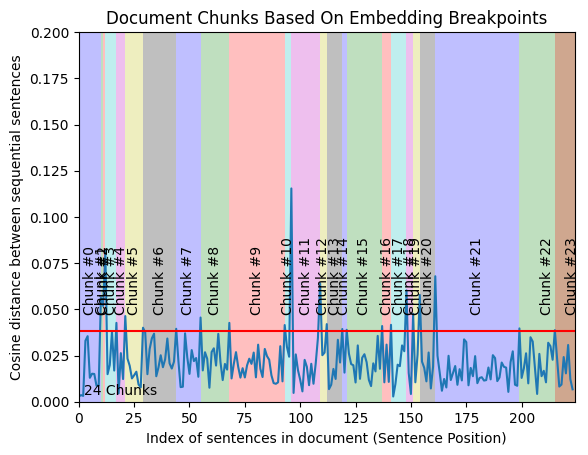

In [23]:
import warnings
import os
import spacy
from IPython.display import display
import ipywidgets as widgets
from llama_index.core import VectorStoreIndex, StorageContext, ServiceContext, load_index_from_storage, Document
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.llms.groq import Groq
from langchain.embeddings import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from PyPDF2 import PdfReader
from neo4j import GraphDatabase

warnings.filterwarnings('ignore')

# ---- NEO4J SETUP ----
neo4j_uri = "neo4j+s://48adb016.databases.neo4j.io"
neo4j_user = "neo4j"
neo4j_password = "uuW6agsPvluczWY89GUJU84XzRPRhcQ9UlNlBKxg4oA"
driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_user, neo4j_password))

# ---- ENVIRONMENT VARIABLES ----
os.environ["GROQ_API_KEY"] = "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"
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

# ---- PROMPT TEMPLATE ----
prompt_template = """
Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Graph Insights: {graph_insights}
Question: {question}

Answer the question and provide additional helpful information,
based on the pieces of information and graph insights, if applicable. Be succinct.

Responses should be properly formatted to be easily read.
"""

# Define the context for your prompt
context = "This directory contains multiple documents providing financial documents."

# Function to read PDF and return text
def read_pdf(file_path):
    text = ""
    with open(file_path, "rb") as file:
        reader = PdfReader(file)
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to split text into sentences
def split_sentences(text):
    text = ' '.join(text.split())
    doc = nlp(text)
    return [{'sentence': sent.text.strip(), 'index': i} for i, sent in enumerate(doc.sents)]

# Function to combine sentences
def combine_sentences(sentences, buffer_size=1):
    for i in range(len(sentences)):
        combined_sentence = ''
        for j in range(i - buffer_size, i):
            if j >= 0:
                combined_sentence += sentences[j]['sentence'] + ' '
        combined_sentence += sentences[i]['sentence']
        for j in range(i + 1, i + 1 + buffer_size):
            if j < len(sentences):
                combined_sentence += ' ' + sentences[j]['sentence']
        sentences[i]['combined_sentence'] = combined_sentence
    return sentences

# Function to compute embeddings
def compute_embeddings(sentences, embedder):
    embeddings = embedder.embed_documents([x['combined_sentence'] for x in sentences])
    for i, sentence in enumerate(sentences):
        sentence['combined_sentence_embedding'] = embeddings[i]
    return sentences

# Function to calculate cosine distances
def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        distance = 1 - similarity
        distances.append(distance)
        sentences[i]['distance_to_next'] = distance
    return distances, sentences

# Function to chunk text
def chunk_text(sentences, distances, breakpoint_percentile_threshold=95):
    breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold)
    indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold]
    chunks = []
    start_index = 0
    for index in indices_above_thresh:
        end_index = index
        group = sentences[start_index:end_index + 1]
        combined_text = ' '.join([d['sentence'] for d in group])
        chunks.append(combined_text)
        start_index = index + 1
    if start_index < len(sentences):
        combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
        chunks.append(combined_text)
    return chunks

# Replace this with your actual document paths
documents_path = ["/content/Fin12.pdf",
                  "/content/Fin13.pdf",
                  "/content/Fin14.pdf"]

all_chunks = []

# Load spacy model (you can choose a different model)
nlp = spacy.load("en_core_web_sm")

# Initialize the embeddings model with API key
OPENAI_API_KEY = 'sk-proj-iXDvNFgNThedT3VorkIfT3BlbkFJkCBkiTpSBlaj3GBnm5v1'
embedder = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

for file_path in documents_path:
    text = read_pdf(file_path)
    sentences = split_sentences(text)
    sentences = combine_sentences(sentences, buffer_size=3)
    sentences = compute_embeddings(sentences, embedder)
    distances, sentences = calculate_cosine_distances(sentences)
    chunks = chunk_text(sentences, distances, breakpoint_percentile_threshold=90)
    all_chunks.append(chunks)

    print(f"Chunks for {file_path}:")
    for i, chunk in enumerate(chunks[:3]):
        print(f"Chunk #{i}:")
        print(chunk[:500])
        print("...")
        print(chunk[-500:])
        print("\n")

# Visualize distances for one of the documents
plt.plot(distances)
y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

breakpoint_distance_threshold = np.percentile(distances, 90)
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-')

num_distances_above_threshold = len([x for x in distances if x > breakpoint_distance_threshold])
plt.text(x=(len(distances) * .01), y=y_upper_bound / 50, s=f"{num_distances_above_threshold + 1} Chunks")

indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)
    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]), y=breakpoint_distance_threshold + (y_upper_bound) / 20, s=f"Chunk #{i}", horizontalalignment='center', rotation='vertical')

if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]), y=breakpoint_distance_threshold + (y_upper_bound) / 20, s=f"Chunk #{i + 1}", rotation='vertical')

plt.title("Document Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in document (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()


In [24]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to retrieve relevant chunks based on query
def retrieve_chunks(query, chunks, embedder):
    # Compute embedding for the query
    query_embedding = embedder.embed_documents([query])[0]

    # Compute embeddings for the chunks if not already computed
    chunk_embeddings = [embedder.embed_documents([chunk])[0] for chunk in chunks]

    # Calculate cosine similarities between query and chunk embeddings
    similarities = cosine_similarity([query_embedding], chunk_embeddings)[0]

    # Retrieve top-k relevant chunks
    top_k_indices = np.argsort(similarities)[::-1]
    top_chunks = [chunks[i] for i in top_k_indices]

    return top_chunks


In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Initialize the re-ranking model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
re_ranker_model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")

# Function to re-rank retrieved chunks
def re_rank_chunks(query, chunks):
    # Prepare the input for re-ranking model
    inputs = tokenizer([query] * len(chunks), chunks, padding=True, truncation=True, return_tensors="pt", max_length=512)

    with torch.no_grad():
        outputs = re_ranker_model(**inputs)

    # Extract scores from outputs
    scores = outputs.logits.squeeze().tolist()

    # Sort chunks based on re-ranking scores
    ranked_chunks = [chunk for _, chunk in sorted(zip(scores, chunks), key=lambda x: x[0], reverse=True)]

    return ranked_chunks


In [29]:
def multi_query_retrieval(queries, all_chunks, embedder):
    results = []
    for query in queries:
        # Retrieve relevant chunks for each query
        top_chunks = retrieve_chunks(query, all_chunks, embedder)
        # Re-rank the retrieved chunks
        re_ranked_chunks = re_rank_chunks(query, top_chunks)
        results.append({
            "query": query,
            "top_chunks": re_ranked_chunks
        })

    return results


In [30]:
def multi_query_retrieval(queries, all_chunks, embedder):
    results = []
    for query in queries:
        # Retrieve relevant chunks for each query
        top_chunks = retrieve_chunks(query, all_chunks, embedder)
        # Re-rank the retrieved chunks
        re_ranked_chunks = re_rank_chunks(query, top_chunks)
        results.append({
            "query": query,
            "top_chunks": re_ranked_chunks
        })

    return results

# Define your queries
queries = [
    "What is the financial performance of the company?",
    "Describe the risks mentioned in the document.",
    "Summarize the key financial figures."
]

# Perform multi-query retrieval and re-ranking
results = multi_query_retrieval(queries, [chunk for sublist in all_chunks for chunk in sublist], embedder)

# Output results
for result in results:
    print(f"Query: {result['query']}")
    print("Top Chunks:")
    for i, chunk in enumerate(result["top_chunks"][:3]):  # Show top 3 chunks
        print(f"Chunk #{i + 1}:")
        print(chunk[:500])
        print("...")
        print(chunk[-500:])
        print("\n")


Query: What is the financial performance of the company?
Top Chunks:
Chunk #1:
This includes press releases and other information about financial performance, information on environmental, social and governance matters, and details related to the Company’ s annual meeting of shareholders. The information contained on the websites referenced in this Form 10-Q is not incorporated by reference into this filing. Further , the Company’ s references to website URLs are intended to be inactive textual references only. Business Seasonality and Product Introductions The Company has
...
during the first quarter of 2023. COVID-19 The COVID-19 pandemic has had, and continues to have, a significant impact around the world, prompting governments and businesses to take unprecedented measures, such as restrictions on travel and business operations, temporary closures of businesses, and quarantine and shelter-in-place orders. The COVID-19 pandemic has at times significantly curtailed global economic ac